In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

/tmp/ipykernel_8001/361038346.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [59]:
df=pd.read_csv('./data/books.csv').drop(columns='index')

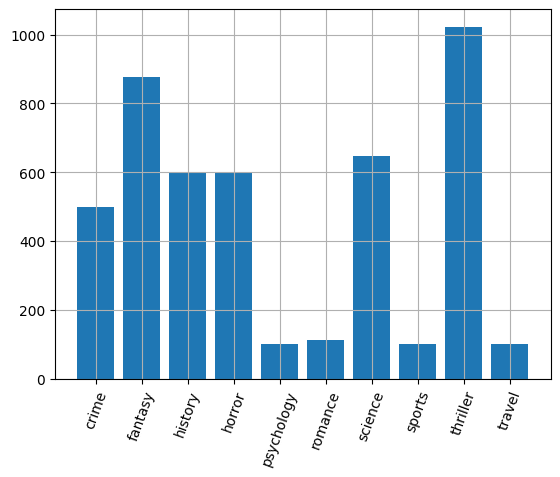

In [3]:
names,counts=np.unique(df.genre, return_counts=True)

plt.bar(np.arange(df.genre.nunique()),
        height=counts)
plt.grid()
plt.xticks(np.arange(df.genre.nunique()), names, rotation=70)
plt.show()

In [18]:
vocab=set()
max_len=0
for summary in tqdm(df.summary.map(lambda s: re.split('\W+',s.strip().lower()))):#[\n ,.;:]
    vocab=vocab.union(set(summary))
    max_len=max(max_len, len(summary))
max_len, len(vocab)

<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_8001/738898365.py:3: SyntaxWarning: invalid escape sequence '\W'
  for summary in tqdm(df.summary.map(lambda s: re.split('\W+',s.strip().lower()))):#[\n ,.;:]
100%|██████████| 4657/4657 [00:04<00:00, 1028.53it/s]


(5750, 55715)

# custom tokenizer

In [23]:
def get_training_corpus():
    for i in range(0, df.shape[0], 100):
        yield df.summary.values[i : i + 100]

In [26]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

In [ ]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

In [16]:
from transformers import GPT2Tokenizer, AutoTokenizer

# gpt2 tokenizer

In [28]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

In [44]:
gpt2_tokenizer(df.summary[0],
          return_tensors='pt',
          padding=True)

{'input_ids': tensor([[  360,  2053,   276,  ...,   110, 19567,   243]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [47]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token 
tokenized_summary=gpt2_tokenizer(df.summary.tolist(),
                    return_tensors='pt',
                    padding=True)
tokenized_summary['input_ids'].shape

torch.Size([4657, 7031])

In [49]:
tokenized_summary['input_ids'].numpy()

array([[  360,  2053,   276, ..., 50256, 50256, 50256],
       [ 1081,   262,  1492, ..., 50256, 50256, 50256],
       [  327,  1018,   417, ..., 50256, 50256, 50256],
       ...,
       [    1,    40,  2107, ..., 50256, 50256, 50256],
       [31087, 10408, 14048, ..., 50256, 50256, 50256],
       [  464,  9005,   286, ..., 50256, 50256, 50256]])

In [52]:
tokenized_summary

{'input_ids': tensor([[  360,  2053,   276,  ..., 50256, 50256, 50256],
        [ 1081,   262,  1492,  ..., 50256, 50256, 50256],
        [  327,  1018,   417,  ..., 50256, 50256, 50256],
        ...,
        [    1,    40,  2107,  ..., 50256, 50256, 50256],
        [31087, 10408, 14048,  ..., 50256, 50256, 50256],
        [  464,  9005,   286,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [55]:
tokenized_summary['input_ids'].numpy().reshape(df.shape[0], 1, -1).shape

(4657, 1, 7031)

In [62]:
df['input_ids']=[list(x) for x in tokenized_summary['input_ids'].numpy()]
df['att_mask']=[list(x) for x in tokenized_summary['attention_mask'].numpy()]

In [64]:
df.to_csv('./data/books.csv')

In [66]:
df.to_parquet('./data/books.par')

In [68]:
pd.read_parquet('./data/books.par')['input_ids'][0]

array([  360,  2053,   276, ..., 50256, 50256, 50256])